In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                     | 0/50000 [00:00<?, ?it/s]

  8%|████████▏                                                                                              | 3946/50000 [00:00<00:01, 39450.26it/s]

 16%|████████████████▋                                                                                      | 8129/50000 [00:00<00:01, 40848.84it/s]

 24%|████████████████████████▉                                                                             | 12214/50000 [00:00<00:00, 40746.08it/s]

 33%|█████████████████████████████████▊                                                                    | 16555/50000 [00:00<00:00, 41793.42it/s]

 41%|██████████████████████████████████████████▎                                                           | 20735/50000 [00:00<00:00, 40807.46it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 24820/50000 [00:00<00:00, 40775.14it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 28901/50000 [00:00<00:00, 39743.80it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 33132/50000 [00:00<00:00, 40537.74it/s]

 75%|████████████████████████████████████████████████████████████████████████████▍                         | 37442/50000 [00:00<00:00, 41322.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 41580/50000 [00:01<00:00, 39627.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 45560/50000 [00:01<00:00, 39248.38it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 49608/50000 [00:01<00:00, 39610.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 40154.32it/s]

Files already downloaded and verified


  0%|                                                                                                                     | 0/10000 [00:00<?, ?it/s]

 31%|████████████████████████████████                                                                       | 3107/10000 [00:00<00:00, 31063.22it/s]

 66%|████████████████████████████████████████████████████████████████████▍                                  | 6648/10000 [00:00<00:00, 33614.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35682.05it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 blu3najq


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-blu3najq:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.6


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_ftr = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_ftr = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_ftr = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_ftr = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_ftr = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_ftr.extend(ftr.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_ftr.extend(ftr.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_ftr.extend(ftr.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_ftr.extend(ftr.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_ftr.extend(ftr.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                       | 0/313 [00:00<?, ?it/s]

  0%|▎                                                                                                              | 1/313 [00:00<02:59,  1.74it/s]

  4%|████▉                                                                                                         | 14/313 [00:00<00:11, 27.10it/s]

  9%|██████████▏                                                                                                   | 29/313 [00:00<00:05, 53.53it/s]

 14%|███████████████                                                                                               | 43/313 [00:00<00:03, 73.82it/s]

 18%|███████████████████▋                                                                                          | 56/313 [00:00<00:02, 87.79it/s]

 22%|████████████████████████▌                                                                                     | 70/313 [00:01<00:02, 99.72it/s]

 27%|█████████████████████████████▎                                                                               | 84/313 [00:01<00:02, 108.61it/s]

 31%|██████████████████████████████████▏                                                                          | 98/313 [00:01<00:01, 115.13it/s]

 36%|██████████████████████████████████████▋                                                                     | 112/313 [00:01<00:01, 119.68it/s]

 40%|███████████████████████████████████████████▏                                                                | 125/313 [00:01<00:01, 122.21it/s]

 44%|███████████████████████████████████████████████▌                                                            | 138/313 [00:01<00:01, 123.79it/s]

 48%|████████████████████████████████████████████████████                                                        | 151/313 [00:01<00:01, 125.01it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 164/313 [00:01<00:01, 125.60it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 177/313 [00:01<00:01, 126.15it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 190/313 [00:02<00:00, 126.52it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 203/313 [00:02<00:00, 126.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 216/313 [00:02<00:00, 127.12it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 229/313 [00:02<00:00, 127.16it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 242/313 [00:02<00:00, 127.25it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 255/313 [00:02<00:00, 126.22it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍               | 268/313 [00:02<00:00, 126.52it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 281/313 [00:02<00:00, 126.78it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 294/313 [00:02<00:00, 126.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 307/313 [00:02<00:00, 126.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 101.61it/s]

train - OK


  0%|                                                                                                                        | 0/79 [00:00<?, ?it/s]

  1%|█▍                                                                                                              | 1/79 [00:00<00:10,  7.42it/s]

 18%|███████████████████▋                                                                                           | 14/79 [00:00<00:00, 69.26it/s]

 34%|█████████████████████████████████████▉                                                                         | 27/79 [00:00<00:00, 94.35it/s]

 51%|███████████████████████████████████████████████████████▋                                                      | 40/79 [00:00<00:00, 107.01it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                    | 53/79 [00:00<00:00, 114.43it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                  | 66/79 [00:00<00:00, 118.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 101.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.96it/s]

val - OK


  0%|                                                                                                                        | 0/79 [00:00<?, ?it/s]

  1%|█▍                                                                                                              | 1/79 [00:00<00:10,  7.41it/s]

 18%|███████████████████▋                                                                                           | 14/79 [00:00<00:00, 68.37it/s]

 34%|█████████████████████████████████████▉                                                                         | 27/79 [00:00<00:00, 92.69it/s]

 51%|███████████████████████████████████████████████████████▋                                                      | 40/79 [00:00<00:00, 105.10it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                    | 53/79 [00:00<00:00, 112.76it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                  | 66/79 [00:00<00:00, 117.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.71it/s]

test InD - OK


  0%|                                                                                                                       | 0/469 [00:00<?, ?it/s]

  0%|▏                                                                                                              | 1/469 [00:00<01:12,  6.46it/s]

  3%|███▎                                                                                                          | 14/469 [00:00<00:07, 63.21it/s]

  6%|██████▎                                                                                                       | 27/469 [00:00<00:04, 89.01it/s]

  9%|█████████▎                                                                                                   | 40/469 [00:00<00:04, 102.99it/s]

 11%|████████████▎                                                                                                | 53/469 [00:00<00:03, 111.44it/s]

 14%|███████████████▎                                                                                             | 66/469 [00:00<00:03, 116.75it/s]

 17%|██████████████████▎                                                                                          | 79/469 [00:00<00:03, 120.12it/s]

 20%|█████████████████████▍                                                                                       | 92/469 [00:00<00:03, 122.55it/s]

 22%|████████████████████████▏                                                                                   | 105/469 [00:00<00:02, 122.91it/s]

 25%|███████████████████████████▏                                                                                | 118/469 [00:01<00:02, 124.23it/s]

 28%|██████████████████████████████▏                                                                             | 131/469 [00:01<00:02, 125.13it/s]

 31%|█████████████████████████████████▏                                                                          | 144/469 [00:01<00:02, 125.85it/s]

 33%|████████████████████████████████████▏                                                                       | 157/469 [00:01<00:02, 126.33it/s]

 36%|███████████████████████████████████████▏                                                                    | 170/469 [00:01<00:02, 126.64it/s]

 39%|██████████████████████████████████████████▏                                                                 | 183/469 [00:01<00:02, 126.83it/s]

 42%|█████████████████████████████████████████████▏                                                              | 196/469 [00:01<00:02, 127.08it/s]

 45%|████████████████████████████████████████████████▏                                                           | 209/469 [00:01<00:02, 127.31it/s]

 47%|███████████████████████████████████████████████████                                                         | 222/469 [00:01<00:01, 127.31it/s]

 50%|██████████████████████████████████████████████████████                                                      | 235/469 [00:01<00:01, 127.40it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 248/469 [00:02<00:01, 127.46it/s]

 56%|████████████████████████████████████████████████████████████                                                | 261/469 [00:02<00:01, 127.39it/s]

 58%|███████████████████████████████████████████████████████████████                                             | 274/469 [00:02<00:01, 127.34it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 287/469 [00:02<00:01, 127.42it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 300/469 [00:02<00:01, 126.43it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 313/469 [00:02<00:01, 126.77it/s]

 70%|███████████████████████████████████████████████████████████████████████████                                 | 326/469 [00:02<00:01, 126.97it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 339/469 [00:02<00:01, 127.16it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 352/469 [00:02<00:00, 127.28it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 365/469 [00:03<00:00, 127.34it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 378/469 [00:03<00:00, 127.51it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 391/469 [00:03<00:00, 127.51it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 404/469 [00:03<00:00, 127.23it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 417/469 [00:03<00:00, 127.41it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 430/469 [00:03<00:00, 127.49it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 443/469 [00:03<00:00, 127.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 456/469 [00:03<00:00, 127.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 108.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.02it/s]

test OoD - OK


  0%|                                                                                                                       | 0/100 [00:00<?, ?it/s]

 14%|███████████████▎                                                                                             | 14/100 [00:00<00:00, 132.35it/s]

 28%|██████████████████████████████▌                                                                              | 28/100 [00:00<00:00, 133.62it/s]

 42%|█████████████████████████████████████████████▊                                                               | 42/100 [00:00<00:00, 133.50it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 56/100 [00:00<00:00, 133.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 70/100 [00:00<00:00, 134.01it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 84/100 [00:00<00:00, 134.49it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 98/100 [00:00<00:00, 134.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 134.11it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(20000, 3, 32, 32) (20000, 2048) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 2048) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 2048) (5000, 512) (5000, 5) (5000,)
(30000, 3, 32, 32) (30000, 2048) (30000, 512) (30000, 5) (30000,)
(6400, 3, 32, 32) (6400, 2048) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


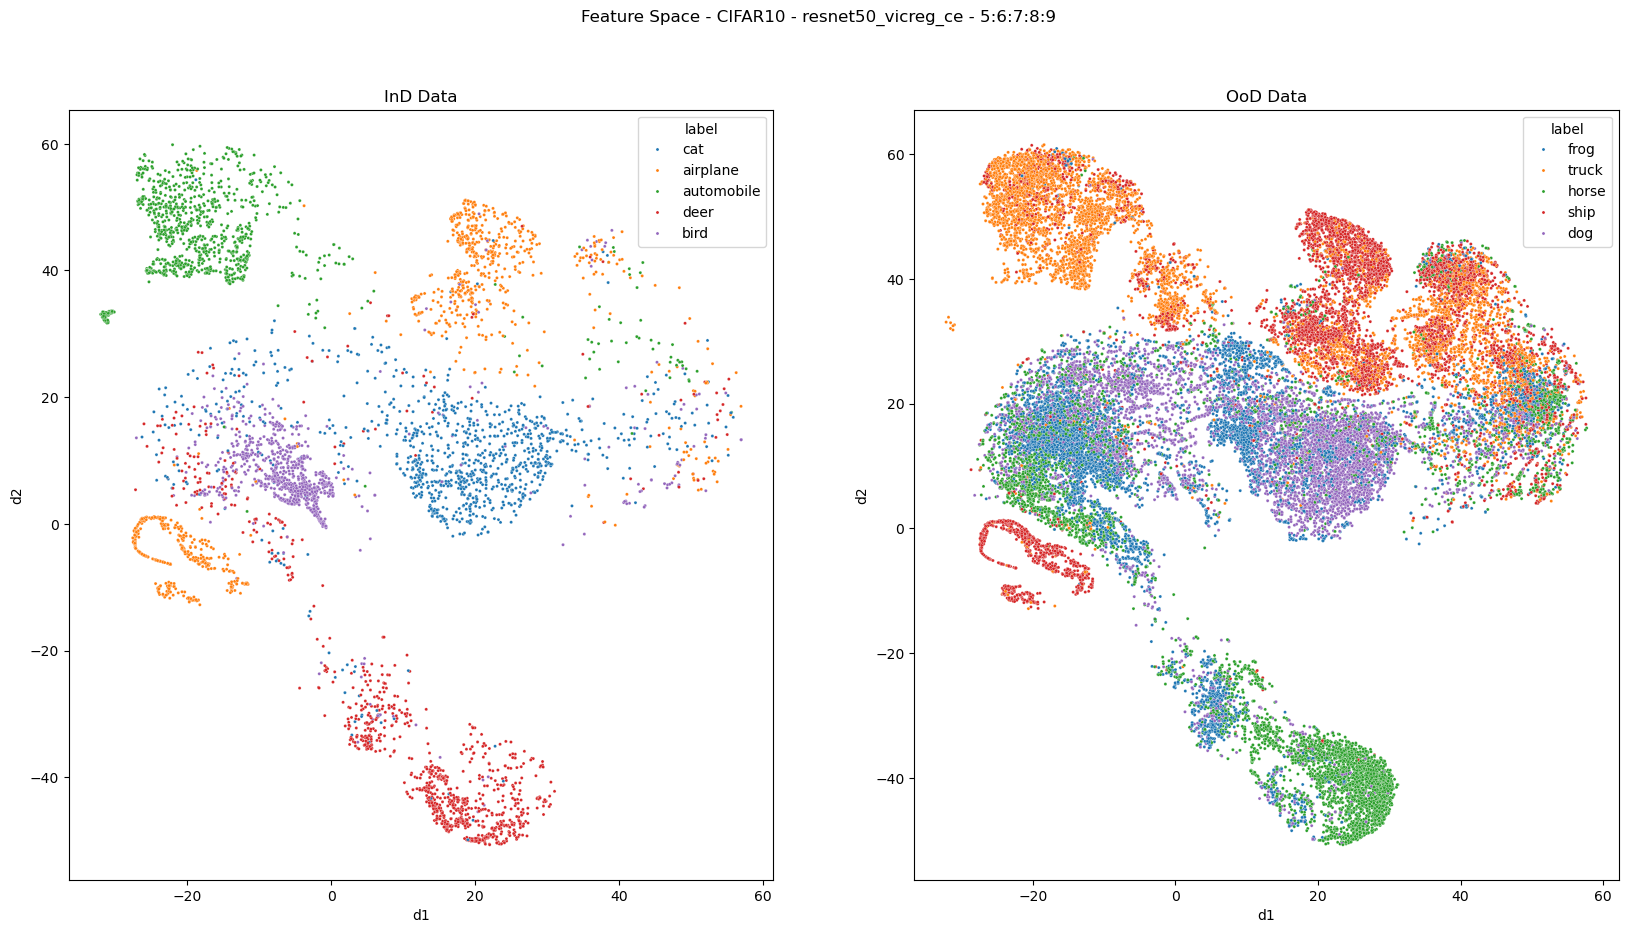

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

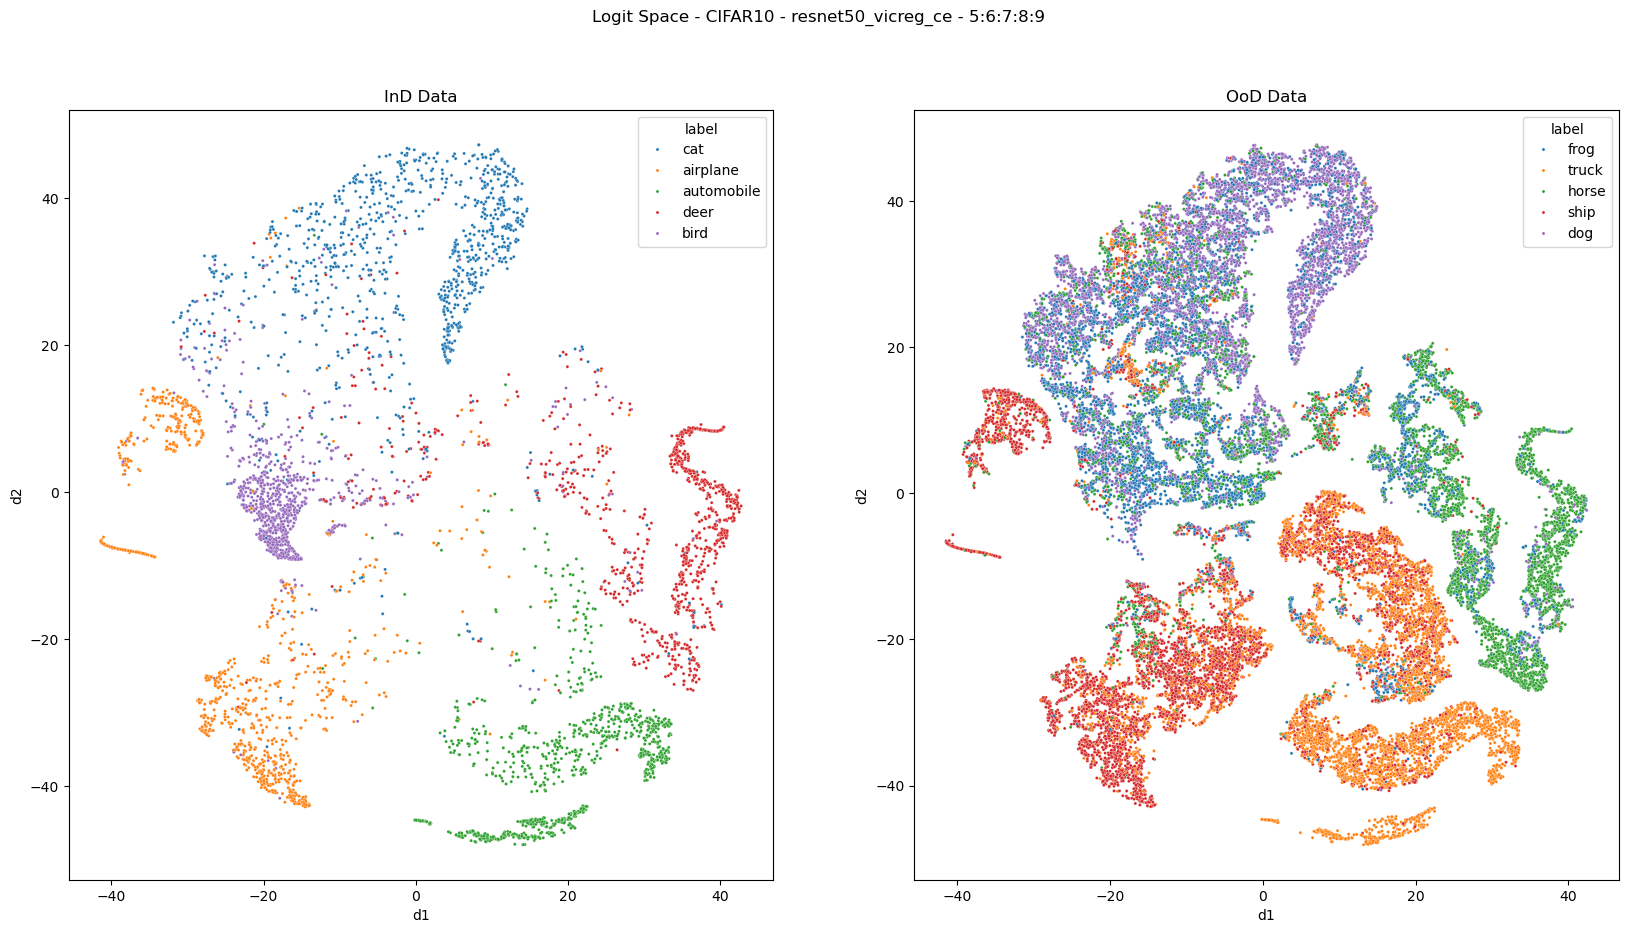

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:04<00:13,  4.38s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:08<00:08,  4.26s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:12<00:04,  4.24s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.28s/it]

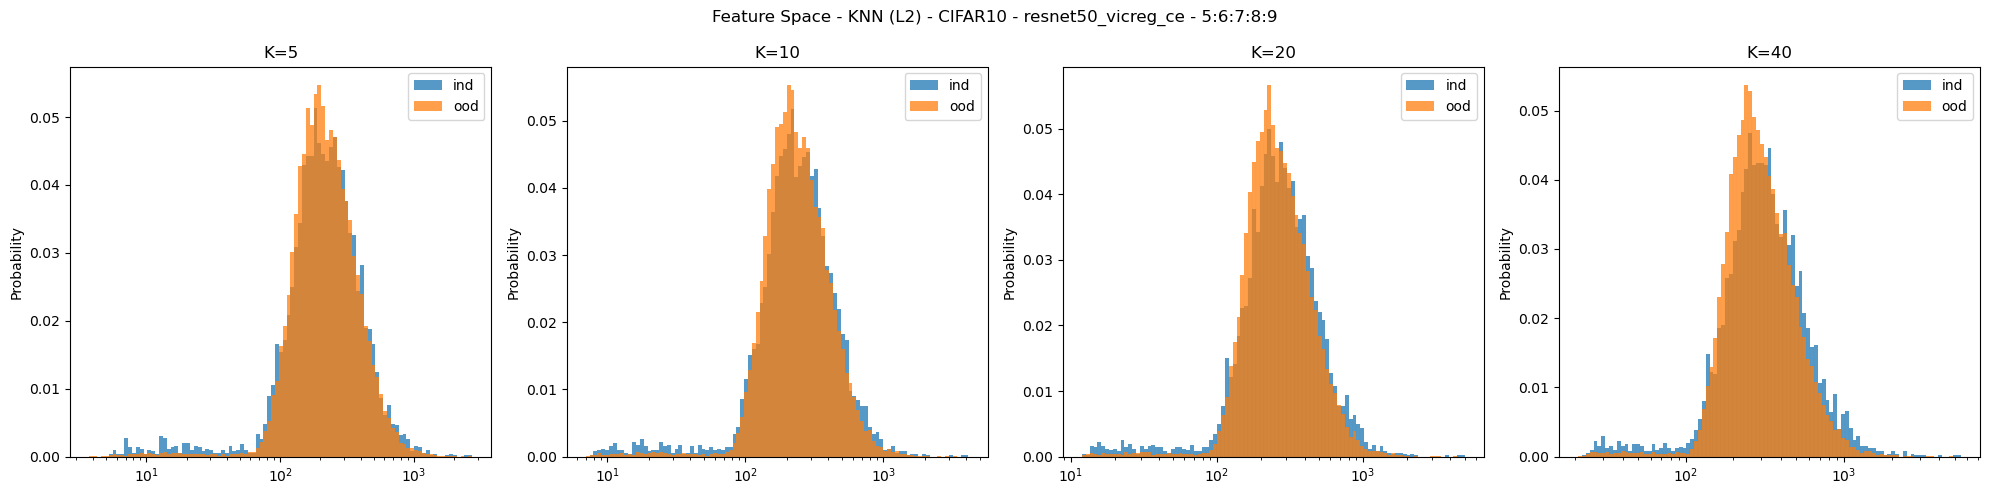

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:03<00:11,  3.97s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:07<00:07,  3.99s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:12<00:04,  4.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.17s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.13s/it]

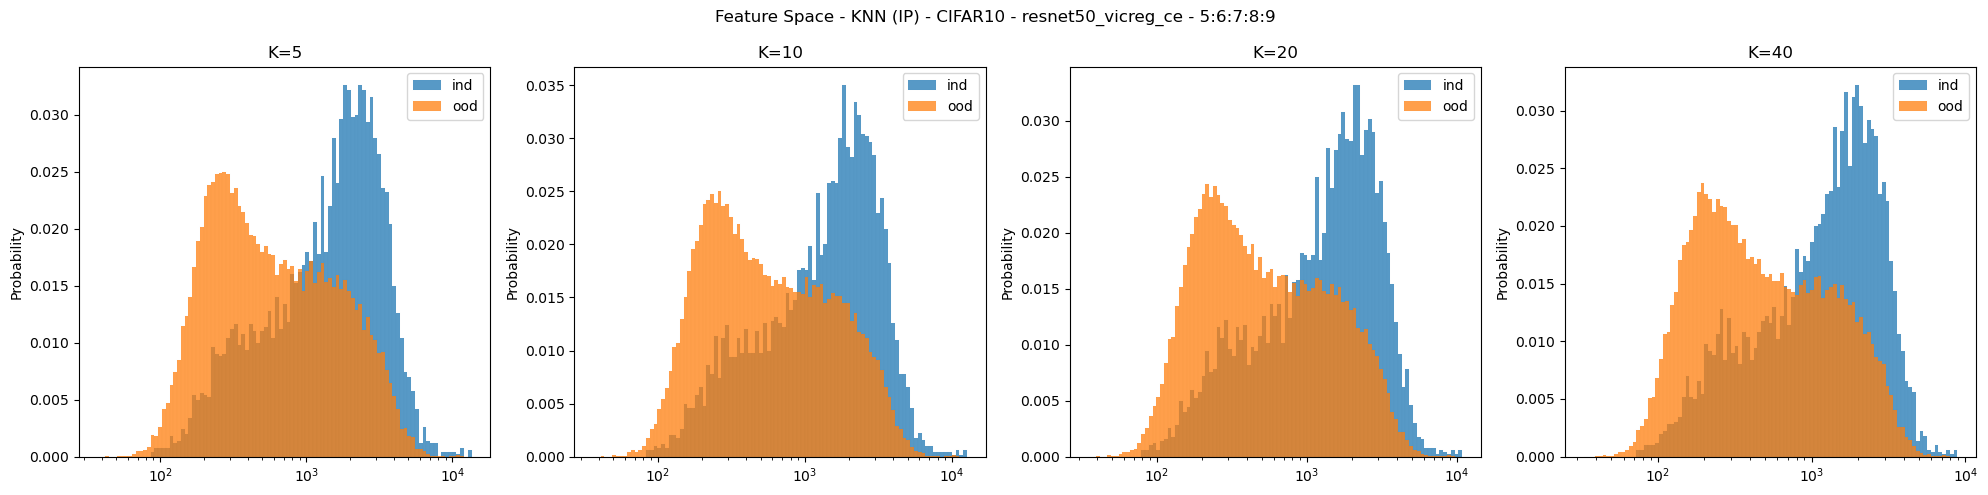

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:04<00:12,  4.06s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:08<00:08,  4.05s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:12<00:04,  4.13s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.22s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.17s/it]

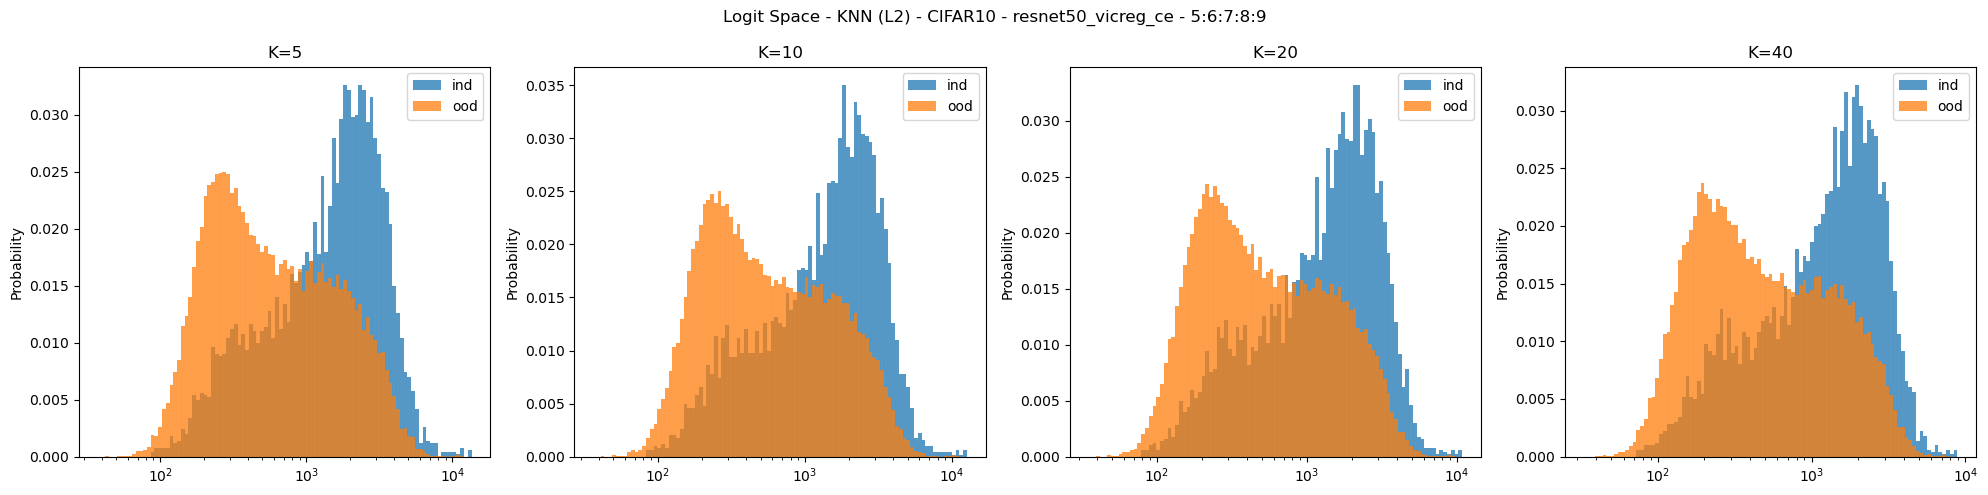

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:04<00:13,  4.43s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:08<00:08,  4.28s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:12<00:04,  4.25s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.28s/it]

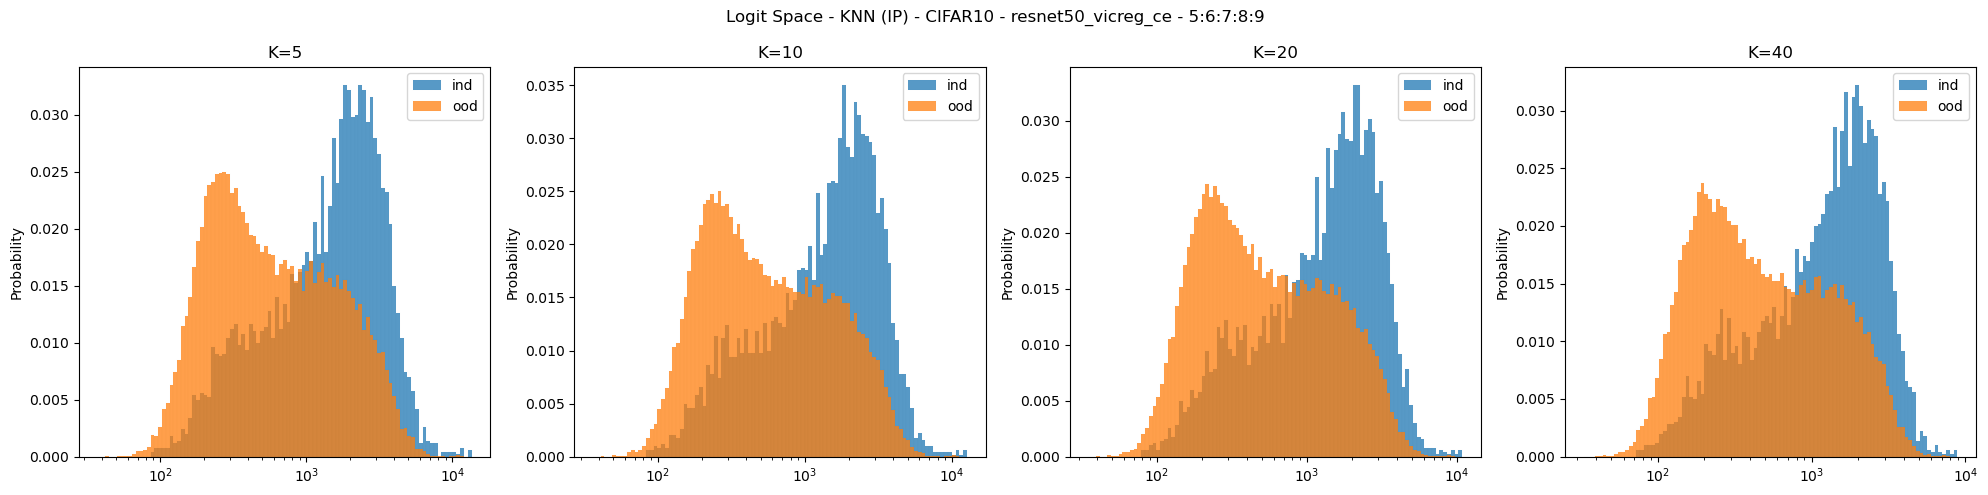

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

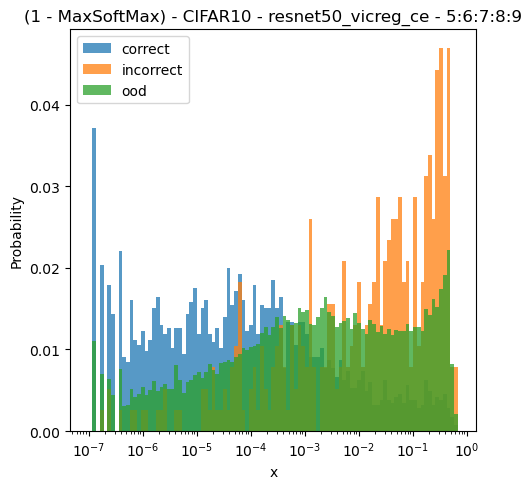

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()